In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-11-23 17:57:29.087689: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 17:57:29.236011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 17:57:30.229452: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import kagglehub
import os

np.random.seed(11232025)
dataset_path = kagglehub.dataset_download('bhavikjikadara/dog-and-cat-classification-dataset')
directory = os.path.join(dataset_path, 'PetImages')

In [3]:
images = []
labels = []

try:
  for foldr in os.listdir(directory):
    for filee in os.listdir(os.path.join(directory, foldr)):
      images.append(os.path.join(foldr, filee))
      labels.append(foldr)

except Exception as e:
  print(f'Error: {e}')

all_df = pd.DataFrame({
    'Images': images,
    'Labels': labels
    })

all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  24998 non-null  object
 1   Labels  24998 non-null  object
dtypes: object(2)
memory usage: 390.7+ KB


In [4]:
all_df.groupby("Labels").count()

,Images
Labels,
Cat,12499
Dog,12499


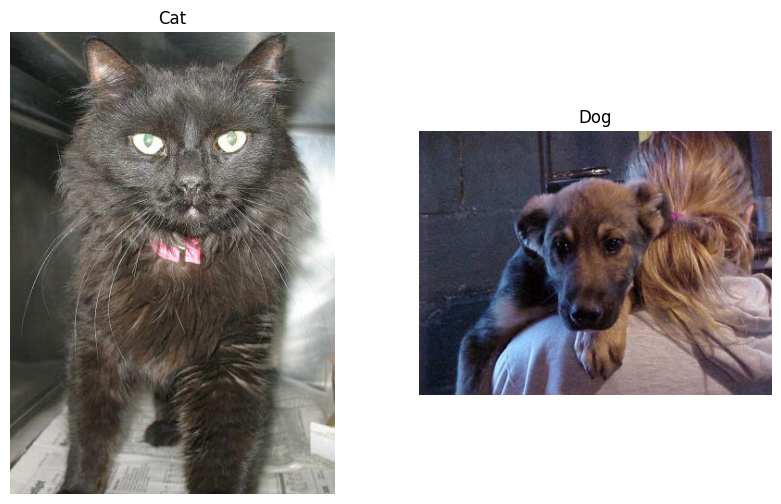

In [5]:
plt.figure(figsize=(10, 6))

for i, label in enumerate(all_df['Labels'].unique()):
    sample = all_df[all_df['Labels'] == label].sample(1).iloc[0]
    img_path = os.path.join(directory, sample['Images'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(all_df['Labels'].unique()), i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=111620206, stratify=all_df['Labels'])

In [7]:
train_df_small = train_df.sample(n=100, random_state=42).reset_index(drop=True)

In [8]:
trainimgen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
    )

train_data = trainimgen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
)




Found 19998 validated image filenames belonging to 2 classes.


In [9]:
testimgen = ImageDataGenerator()

test_data = testimgen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=False # ensures the prediction order matches the label order
)

Found 5000 validated image filenames belonging to 2 classes.


## Model Time

In [10]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_std=1.0):
        super(BayesianLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior_std = prior_std

        # Initialize mu with Xavier initialization
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight_mu)
        
        self.bias_mu = nn.Parameter(torch.zeros(out_features))

        initial_std = 0.001 
        # initial_std = prior_std
        initial_rho = torch.log(torch.tensor(initial_std))
        
        self.weight_rho = nn.Parameter(torch.ones_like(self.weight_mu) * initial_rho)
        self.bias_rho = nn.Parameter(torch.ones_like(self.bias_mu) * initial_rho)

    def forward(self, x):
        weight_std = F.softplus(self.weight_rho)
        weight = self.weight_mu + weight_std * torch.randn_like(self.weight_mu)

        bias_std = F.softplus(self.bias_rho)
        bias = self.bias_mu + bias_std * torch.randn_like(self.bias_mu)

        return F.linear(x, weight, bias)

    def kl_divergence(self):
        weight_std = F.softplus(self.weight_rho)
        bias_std = F.softplus(self.bias_rho)

        # KL between N(mu, std) and N(0, prior_std)
        kl_weight = self._kl_normal(self.weight_mu, weight_std, self.prior_std)
        kl_bias = self._kl_normal(self.bias_mu, bias_std, self.prior_std)
        
        return kl_weight + kl_bias

    def _kl_normal(self, mu, std, prior_std):
        prior_var = prior_std ** 2
        var = std ** 2
        
        kl = 0.5 * (torch.log(prior_var / var) + (var + mu**2) / prior_var - 1)
        return kl.sum()


class BayesianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, prior_std=1.0):
        super(BayesianConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.stride = stride
        self.prior_std = prior_std

        # Initialize with Kaiming (He) initialization for conv layers
        self.weight_mu = nn.Parameter(torch.Tensor(
            out_channels, in_channels, *self.kernel_size))
        nn.init.kaiming_normal_(self.weight_mu, mode='fan_out', nonlinearity='relu')
        
        self.bias_mu = nn.Parameter(torch.zeros(out_channels))

        # Initialize rho for initial std = 0.05 (smaller for conv layers)
        initial_std = 0.0005
        # initial_std = prior_std
        initial_rho = torch.log(torch.tensor(initial_std))
        
        self.weight_rho = nn.Parameter(torch.ones_like(self.weight_mu) * initial_rho)
        self.bias_rho = nn.Parameter(torch.ones_like(self.bias_mu) * initial_rho)

    def forward(self, x):
        weight_std = F.softplus(self.weight_rho)
        weight = self.weight_mu + weight_std * torch.randn_like(self.weight_mu)

        bias_std = F.softplus(self.bias_rho)
        bias = self.bias_mu + bias_std * torch.randn_like(self.bias_mu)

        return F.conv2d(x, weight, bias, stride=self.stride, padding=self.padding)

    def kl_divergence(self):
        weight_std = F.softplus(self.weight_rho)
        bias_std = F.softplus(self.bias_rho)

        kl_weight = self._kl_normal(self.weight_mu, weight_std, self.prior_std)
        kl_bias = self._kl_normal(self.bias_mu, bias_std, self.prior_std)
        
        return kl_weight + kl_bias

    def _kl_normal(self, mu, std, prior_std):
        prior_var = prior_std ** 2
        var = std ** 2
        
        kl = 0.5 * (torch.log(prior_var / var) + (var + mu**2) / prior_var - 1)
        return kl.sum()


class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()

        # Use larger prior std for early layers, smaller for later layers
        self.conv1 = BayesianConv2d(3, 16, kernel_size=3, padding=1, prior_std=0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BayesianConv2d(16, 32, kernel_size=3, padding=1, prior_std=0.05)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BayesianConv2d(32, 64, kernel_size=3, padding=1, prior_std=0.05)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = BayesianLinear(28*28*64, 128, prior_std=0.05)
        self.fc2 = BayesianLinear(128, 2, prior_std=0.05)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def kl_divergence(self):
        # Total KL divergence for the network
        kl = 0
        kl += self.conv1.kl_divergence()
        kl += self.conv2.kl_divergence()
        kl += self.conv3.kl_divergence()
        kl += self.fc1.kl_divergence()
        kl += self.fc2.kl_divergence()
        return kl

    def predict_with_uncertainty(self, x, num_samples=100):
        self.train()  # Keep in train mode to sample weights
        predictions = []

        with torch.no_grad():
            for _ in range(num_samples):
                output = self(x)
                probs = F.softmax(output, dim=1)
                predictions.append(probs)

        predictions = torch.stack(predictions)  # [num_samples, batch_size, num_classes]

        mean_predictions = predictions.mean(dim=0)
        std_predictions = predictions.std(dim=0)

        return mean_predictions, std_predictions, predictions

class ParameterTracker:
    # Track specific parameters during training
    def __init__(self, model, num_params_to_track=10):
        self.history = {
            'conv1_weight_mu': [],
            'conv1_weight_sigma': [],
            'fc1_weight_mu': [],
            'fc1_weight_sigma': [],
            'fc2_bias_mu': [],
            'fc2_bias_sigma': [],
        }

        # Randomly select indices to track
        conv1_size = model.conv1.weight_mu.numel()
        fc1_size = model.fc1.weight_mu.numel()
        fc2_bias_size = model.fc2.bias_mu.numel()

        self.indices = {
            'conv1': np.random.choice(conv1_size, num_params_to_track, replace=False),
            'fc1': np.random.choice(fc1_size, num_params_to_track, replace=False),
            'fc2_bias': np.random.choice(fc2_bias_size, min(num_params_to_track, fc2_bias_size), replace=False),
        }

    def record(self, model):
        # Conv1 weights
        weight_mu = model.conv1.weight_mu.detach().cpu().flatten().numpy()
        weight_rho = model.conv1.weight_rho.detach().cpu().flatten().numpy()
        weight_sigma = np.log1p(np.exp(weight_rho))
        self.history['conv1_weight_mu'].append(weight_mu[self.indices['conv1']])
        self.history['conv1_weight_sigma'].append(weight_sigma[self.indices['conv1']])

        # FC1 weights
        weight_mu = model.fc1.weight_mu.detach().cpu().flatten().numpy()
        weight_rho = model.fc1.weight_rho.detach().cpu().flatten().numpy()
        weight_sigma = np.log1p(np.exp(weight_rho))
        self.history['fc1_weight_mu'].append(weight_mu[self.indices['fc1']])
        self.history['fc1_weight_sigma'].append(weight_sigma[self.indices['fc1']])

        # FC2 biases
        bias_mu = model.fc2.bias_mu.detach().cpu().numpy()
        bias_rho = model.fc2.bias_rho.detach().cpu().numpy()
        bias_sigma = np.log1p(np.exp(bias_rho))
        self.history['fc2_bias_mu'].append(bias_mu[self.indices['fc2_bias']])
        self.history['fc2_bias_sigma'].append(bias_sigma[self.indices['fc2_bias']])

    def plot_evolution(self):
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle('Parameter Evolution During Training', fontsize=16)

        epochs = np.arange(len(self.history['conv1_weight_mu']))

        # Conv1 weight mu
        for i in range(len(self.indices['conv1'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['conv1_weight_mu']]
            axes[0, 0].plot(epochs, mu_values, alpha=0.7, label=f'Weight {i}')
        axes[0, 0].set_title('Conv1 Weight μ Evolution')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('μ value')
        axes[0, 0].grid(alpha=0.3)

        # Conv1 weight sigma
        for i in range(len(self.indices['conv1'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['conv1_weight_sigma']]
            axes[0, 1].plot(epochs, sigma_values, alpha=0.7, label=f'Weight {i}')
        axes[0, 1].set_title('Conv1 Weight σ Evolution')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('σ value')
        axes[0, 1].grid(alpha=0.3)

        # FC1 weight mu
        for i in range(len(self.indices['fc1'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['fc1_weight_mu']]
            axes[1, 0].plot(epochs, mu_values, alpha=0.7)
        axes[1, 0].set_title('FC1 Weight μ Evolution')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('μ value')
        axes[1, 0].grid(alpha=0.3)

        # FC1 weight sigma
        for i in range(len(self.indices['fc1'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['fc1_weight_sigma']]
            axes[1, 1].plot(epochs, sigma_values, alpha=0.7)
        axes[1, 1].set_title('FC1 Weight σ Evolution')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('σ value')
        axes[1, 1].grid(alpha=0.3)

        # FC2 bias mu
        for i in range(len(self.indices['fc2_bias'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['fc2_bias_mu']]
            axes[2, 0].plot(epochs, mu_values, alpha=0.7, marker='o', markersize=3)
        axes[2, 0].set_title('FC2 Bias μ Evolution')
        axes[2, 0].set_xlabel('Epoch')
        axes[2, 0].set_ylabel('μ value')
        axes[2, 0].grid(alpha=0.3)

        # FC2 bias sigma
        for i in range(len(self.indices['fc2_bias'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['fc2_bias_sigma']]
            axes[2, 1].plot(epochs, sigma_values, alpha=0.7, marker='o', markersize=3)
        axes[2, 1].set_title('FC2 Bias σ Evolution')
        axes[2, 1].set_xlabel('Epoch')
        axes[2, 1].set_ylabel('σ value')
        axes[2, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BayesianCNN().to(device)
model

Using device: cuda


BayesianCNN(
  (conv1): BayesianConv2d()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BayesianConv2d()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BayesianConv2d()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): BayesianLinear()
  (fc2): BayesianLinear()
)

In [12]:
print(f"train_data will have {len(train_data)} batches")

train_data will have 1250 batches


In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

save_dir = '../models/'

In [14]:
len(train_df)

19998

## Training

In [15]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# tracker = ParameterTracker(model, num_params_to_track=10)
# tracker.record(model)

# # Calculate beta based on total number of training samples
# max_beta = 1.0 / len(train_df)
# print(f"Beta: {max_beta:.8f}")

# num_epochs = 50
# num_batches = len(train_data)
# train_losses = []
# val_accuracies = []

# # Early stopping parameters
# best_val_accuracy = 0.0
# patience = 10
# patience_counter = 0

# # Number of forward passes for validation (Monte Carlo sampling)
# num_mc_samples = 10

# for epoch in range(num_epochs):
#     beta = 0.0 if epoch < 3 else max_beta * 0.2
#     model.train()

#     total_loss = 0
#     total_nll = 0
#     total_kl = 0

#     for batch_idx, (data, target) in enumerate(train_data):
#         if batch_idx >= num_batches:
#             break

#         data = torch.FloatTensor(data).to(device)
#         target = torch.LongTensor(target.astype(int)).to(device)

#         if data.max() > 1.0:
#             data = data / 255.0

#         data = data.permute(0, 3, 1, 2)

#         # Forward pass
#         output = model(data)
#         nll_loss = F.cross_entropy(output, target)
#         kl_loss = model.kl_divergence()
#         loss = nll_loss + beta * kl_loss

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         total_nll += nll_loss.item()
#         total_kl += kl_loss.item()

#     avg_loss = total_loss / len(train_data)
#     avg_nll = total_nll / len(train_data)
#     avg_kl = total_kl / len(train_data)
#     train_losses.append(avg_loss)

#     tracker.record(model)

#     print(f'Epoch {epoch+1}/{num_epochs}:')
#     print(f'Loss: {avg_loss:.3f} (NLL: {avg_nll:.3f}, KL: {avg_kl:.3f})')

#     # ============ VALIDATION ACCURACY ============
#     if (epoch + 1) % 2 == 0:
#         model.train()
#         correct = 0
#         total = 0

#         with torch.no_grad():
#             for batch_idx, (data, target) in enumerate(test_data):
#                 if batch_idx >= len(test_data):
#                     break

#                 data = torch.FloatTensor(data).to(device)
#                 target = torch.LongTensor(target.astype(int)).to(device)

#                 if data.max() > 1.0:
#                     data = data / 255.0

#                 data = data.permute(0, 3, 1, 2)

#                 # Perform multiple forward passes
#                 predictions = []
#                 for _ in range(num_mc_samples):
#                     outputs = model(data)
#                     predictions.append(F.softmax(outputs, dim=1))

#                 # Average predictions across all forward passes
#                 avg_predictions = torch.stack(predictions).mean(dim=0)
#                 _, predicted = torch.max(avg_predictions, 1)

#                 total += target.size(0)
#                 correct += (predicted == target).sum().item()

#         val_accuracy = 100 * correct / total
#         val_accuracies.append(val_accuracy)
#         print(f'  Validation Accuracy (MC samples={num_mc_samples}): {val_accuracy:.2f}%')

#         # Early stopping check
#         if val_accuracy > best_val_accuracy:
#             best_val_accuracy = val_accuracy
#             patience_counter = 0
#             # Save best model
#             torch.save({
#                 'epoch': epoch + 1,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_losses': train_losses,
#                 'val_accuracies': val_accuracies,
#                 'best_val_accuracy': best_val_accuracy,
#                 'tracker_history': tracker.history,
#                 'tracker_indices': tracker.indices,
#             }, f'{save_dir}/best_bayesian_cnn_catdog.pth')
#             print(f'New best model saved! (Val Acc: {val_accuracy:.2f}%)')
#         else:
#             patience_counter += 1
#             print(f'No improvement. Patience: {patience_counter}/{patience}')

#             if patience_counter >= patience:
#                 print(f'Early stopping triggered at epoch {epoch+1}')
#                 print(f'Best validation accuracy: {best_val_accuracy:.2f}%')
#                 break

#     if (epoch + 1) % 5 == 0:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_losses': train_losses,
#             'val_accuracies': val_accuracies,
#             'tracker_history': tracker.history,
#             'tracker_indices': tracker.indices,
#         }, f'{save_dir}/bayes_checkpoint_epoch_{epoch+1}.pth')
#         print(f"Checkpoint saved at epoch {epoch+1}")


# # Save the final model
# torch.save({
#     'epoch': epoch + 1,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_losses': train_losses,
#     'val_accuracies': val_accuracies,
#     'tracker_history': tracker.history,
#     'tracker_indices': tracker.indices,
#     'best_val_accuracy': best_val_accuracy,
# }, f'{save_dir}/bayes_cnn_catdog_final.pth')

# print(f"Training completed!")
# print(f"Final model saved as 'bayesian_cnn_catdog_final.pth'")
# print(f"Best model saved as 'best_bayesian_cnn_catdog.pth'")
# print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

In [16]:
# # Plot training loss and validation accuracy
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Plot training loss
# ax1.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Training Loss')
# ax1.set_title('Training Loss over Epochs (Bayesian CNN)')
# ax1.set_yscale('log') 
# ax1.grid(True)

# # Plot validation accuracy
# val_epochs = list(range(2, 2 * len(val_accuracies) + 1, 2))
# ax2.plot(val_epochs, val_accuracies, marker='o', color='green')
# ax2.axhline(y=best_val_accuracy, color='r', linestyle='--', label=f'Best: {best_val_accuracy:.2f}%')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Validation Accuracy (%)')
# ax2.set_title('Validation Accuracy over Epochs (Bayesian CNN)')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

# print(f"Final Training Loss: {train_losses[-1]:.3f}")
# if len(val_accuracies) > 0:
#     print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BayesianCNN().to(device)
checkpoint = torch.load(f'{save_dir}/best_bayesian_cnn_catdog.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BayesianCNN(
  (conv1): BayesianConv2d()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BayesianConv2d()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BayesianConv2d()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): BayesianLinear()
  (fc2): BayesianLinear()
)

## Analysis

In [18]:
# ============ PREDICTIONS ============

# Prepare test data by converting from ImageDataGenerator to numpy arrays
print("Converting test data to numpy arrays...")
X_test = []
y_test = []

for batch_idx, (data, target) in enumerate(test_data):
    X_test.append(data)
    y_test.append(target)

    # Break after we've gone through all batches
    if batch_idx >= len(test_data) - 1:
        break

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


Converting test data to numpy arrays...
Test data shape: (5000, 224, 224, 3)
Test labels shape: (5000,)


-Processed 0/5000 images...
-Processed 320/5000 images...
-Processed 640/5000 images...
-Processed 960/5000 images...
-Processed 1280/5000 images...
-Processed 1600/5000 images...
-Processed 1920/5000 images...
-Processed 2240/5000 images...
-Processed 2560/5000 images...
-Processed 2880/5000 images...
-Processed 3200/5000 images...
-Processed 3520/5000 images...
-Processed 3840/5000 images...
-Processed 4160/5000 images...
-Processed 4480/5000 images...
-Processed 4800/5000 images...
Predictions complete! Shape: (5000,)
Prediction probabilities shape: (5000, 2)
Sample predictions (first 5):
Class predictions: [0 1 0 1 1]
Probabilities:[[0.79921186 0.20078819]
 [0.23312046 0.7668796 ]
 [0.56666946 0.43333054]
 [0.03333334 0.9666667 ]
 [0.39992595 0.6000741 ]]
Probability sums: [1.        1.0000001 1.        1.        1.       ]


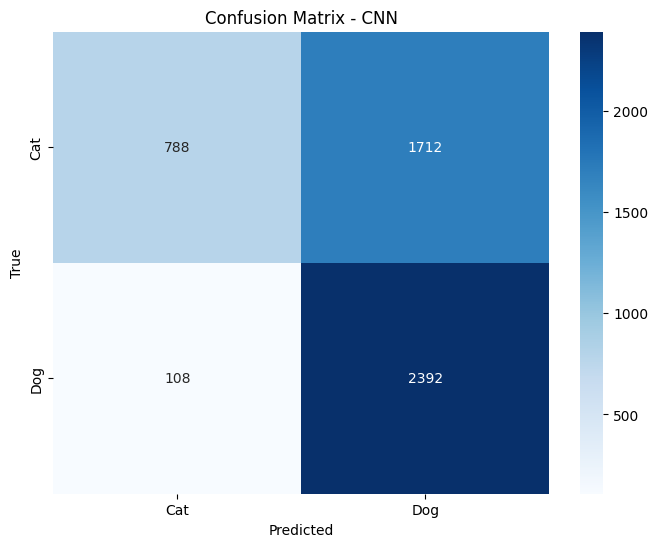

              precision    recall  f1-score   support

         Cat       0.88      0.32      0.46      2500
         Dog       0.58      0.96      0.72      2500

    accuracy                           0.64      5000
   macro avg       0.73      0.64      0.59      5000
weighted avg       0.73      0.64      0.59      5000



In [19]:
model.eval()
y_pred_list = []
y_pred_proba_list = []
batch_size = 32
# batch_size = 16
num_samples = 30

with torch.no_grad():
    for i in range(0,len(X_test), batch_size):
        batch_end = min(i + batch_size, len(X_test))
        batch_data = X_test[i:batch_end]
        batch_tensor = torch.FloatTensor(batch_data).permute(0, 3, 1, 2).to(device)
        
        batch_mean_probs, batch_std, _ = model.predict_with_uncertainty(batch_tensor, num_samples=num_samples)
        batch_pred = torch.argmax(batch_mean_probs, dim=1)
        
        # Move predictions back to CPU and store
        y_pred_list.extend(batch_pred.cpu().numpy())
        y_pred_proba_list.extend(batch_mean_probs.cpu().numpy())
        
        # Clear GPU memory
        del batch_tensor, batch_mean_probs, batch_std, batch_pred
        torch.cuda.empty_cache()
        
        if (i // batch_size) % 10 == 0:
            print(f"-Processed {i}/{len(X_test)} images...")

y_pred = np.array(y_pred_list)
y_pred_proba = np.array(y_pred_proba_list) 
y_test_true = y_test.astype(int)

print(f"Predictions complete! Shape: {y_pred.shape}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")
print(f"Sample predictions (first 5):")
print(f"Class predictions: {y_pred[:5]}")
print(f"Probabilities:{y_pred_proba[:5]}")
print(f"Probability sums: {y_pred_proba[:5].sum(axis=1)}")

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN')
plt.show()

print(classification_report(y_test_true, y_pred,
                          target_names=['Cat', 'Dog']))

Uncertainty analysis

Confidence Distribution:
-Mean confidence: 0.819
-Median confidence: 0.859
-Min confidence: 0.500
-Max confidence: 1.000
Confidence for CORRECT predictions:
-Mean: 0.853
-Median: 0.901
Confidence for INCORRECT predictions:
-Mean: 0.761
-Median: 0.759


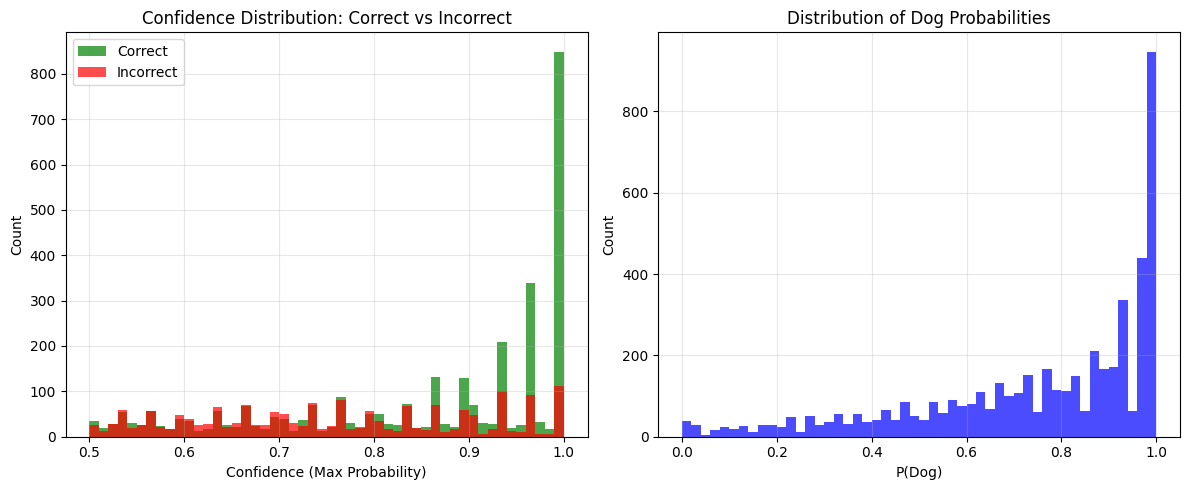

In [20]:
max_probs = y_pred_proba.max(axis=1)
print(f"Confidence Distribution:")
print(f"-Mean confidence: {max_probs.mean():.3f}")
print(f"-Median confidence: {np.median(max_probs):.3f}")
print(f"-Min confidence: {max_probs.min():.3f}")
print(f"-Max confidence: {max_probs.max():.3f}")

# Correct vs incorrect predictions
correct_mask = (y_pred == y_test_true)
incorrect_mask = ~correct_mask

print(f"Confidence for CORRECT predictions:")
print(f"-Mean: {max_probs[correct_mask].mean():.3f}")
print(f"-Median: {np.median(max_probs[correct_mask]):.3f}")

print(f"Confidence for INCORRECT predictions:")
print(f"-Mean: {max_probs[incorrect_mask].mean():.3f}")
print(f"-Median: {np.median(max_probs[incorrect_mask]):.3f}")

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(max_probs[correct_mask], bins=50, alpha=0.7, label='Correct', color='green')
plt.hist(max_probs[incorrect_mask], bins=50, alpha=0.7, label='Incorrect', color='red')
plt.xlabel('Confidence (Max Probability)')
plt.ylabel('Count')
plt.title('Confidence Distribution: Correct vs Incorrect')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(y_pred_proba[:, 1], bins=50, alpha=0.7, color='blue')
plt.xlabel('P(Dog)')
plt.ylabel('Count')
plt.title('Distribution of Dog Probabilities')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Test Accuracy: 0.636
Total misclassified: 1820


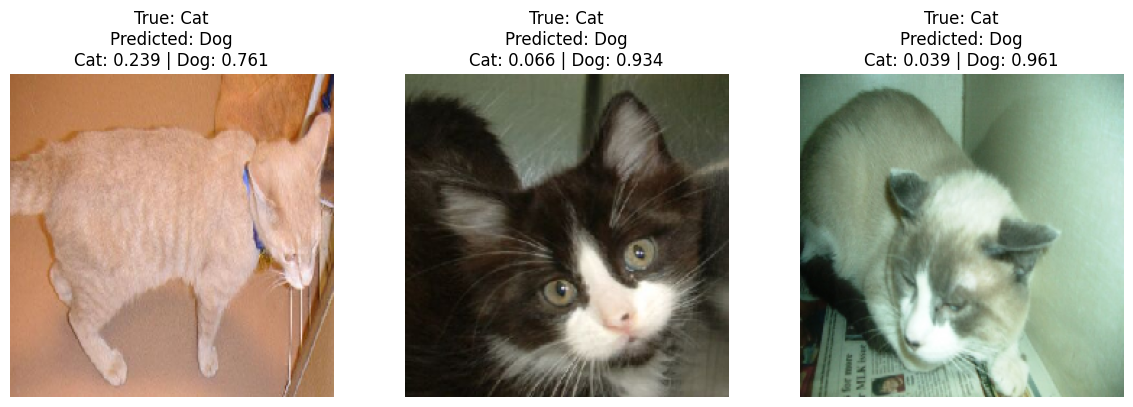

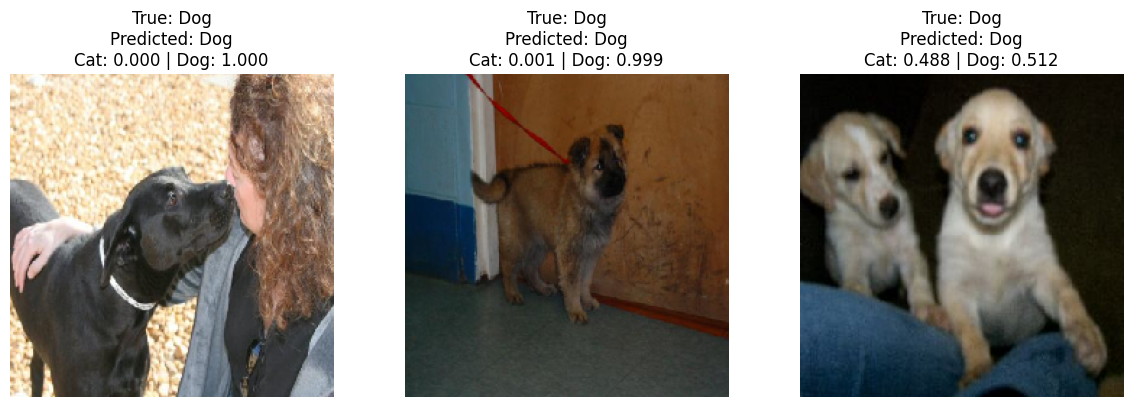

In [21]:
accuracy = (y_pred == y_test_true).mean()
print(f"Test Accuracy: {accuracy:.3f}")

# Find misclassified examples
misclassified_idx = np.where(y_pred != y_test_true)[0]
print(f"Total misclassified: {len(misclassified_idx)}")

n_examples = min(3, len(misclassified_idx))
random_idx = np.random.choice(misclassified_idx, n_examples, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
class_names = ['Cat', 'Dog']

for i, idx in enumerate(random_idx):
    img = X_test[idx].astype(np.uint8)
    cat_prob = y_pred_proba[idx][0]  # Probability for Cat
    dog_prob = y_pred_proba[idx][1]  # Probability for Dog
    
    axes[i].imshow(img)
    axes[i].set_title(f"True: {class_names[y_test_true[idx]]}\n"
                     f"Predicted: {class_names[y_pred[idx]]}\n"
                     f"Cat: {cat_prob:.3f} | Dog: {dog_prob:.3f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Correct predictions
correct_idx = np.where(y_pred == y_test_true)[0]
n_correct = min(3, len(correct_idx))
correct_random_idx = np.random.choice(correct_idx, n_correct, replace=False)

# Plot the correctly classified images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(correct_random_idx):
    img = X_test[idx].astype(np.uint8)
    cat_prob = y_pred_proba[idx][0]
    dog_prob = y_pred_proba[idx][1]
    
    axes[i].imshow(img)
    axes[i].set_title(f"True: {class_names[y_test_true[idx]]}\n"
                     f"Predicted: {class_names[y_pred[idx]]}\n"
                     f"Cat: {cat_prob:.3f} | Dog: {dog_prob:.3f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [22]:
def plot_prediction_with_uncertainty(idx, is_correct):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    img = X_test[idx]
    
    # Normalize image to [0, 1] range for proper display
    if img.dtype == np.float32 or img.dtype == np.float64:
        if img.max() > 1.0:
            img = img / 255.0 
    
    if img.shape[-1] == 3:
        axes[0].imshow(img)
    else:  # Grayscale
        axes[0].imshow(img.squeeze(), cmap='gray')
    
    # Get class names
    class_names = ['Cat', 'Dog']
    
    axes[0].set_title(f"True: {class_names[y_test_true_np[idx]]}, "
                      f"Pred: {class_names[predicted_classes[idx]]}, "
                      f"Max Uncertainty: {max_uncertainties[idx]:.3f}")
    axes[0].axis('off')
    
    # Plot prediction probabilities with uncertainty bars
    classes = np.arange(2)  # Changed from 10 to 2
    axes[1].bar(classes, mean_preds[idx], alpha=0.7, label='Mean Probability')
    axes[1].errorbar(classes, mean_preds[idx], yerr=std_preds[idx],
                     fmt='none', ecolor='red', capsize=5, label='Uncertainty (±1 std)')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Probability')
    axes[1].set_title('Prediction Distribution')
    axes[1].set_xticks(classes)
    axes[1].set_xticklabels(class_names) 
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim([0, 1]) 
    
    plt.tight_layout()
    plt.show()
    
    print(f"Detailed stats for sample {idx}:")
    print(f"True label: {class_names[y_test_true_np[idx]]}")
    print(f"Predicted label: {class_names[predicted_classes[idx]]}")
    print(f"Confidence (max probability): {mean_preds[idx].max():.3f}")
    print(f"Uncertainty in prediction: {std_preds[idx][predicted_classes[idx]]:.3f}")
    print(f"Max uncertainty across classes: {max_uncertainties[idx]:.3f}")
    print("Prediction probabilities:")
    for class_idx in range(2):
        print(f"-{class_names[class_idx]}: {mean_preds[idx][class_idx]:.3f} ± {std_preds[idx][class_idx]:.3f}")

In [23]:
batch_size = 32
num_samples = 30

mean_preds_list = []
std_preds_list = []

print("Getting predictions with uncertainty in batches...")

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch_end = min(i + batch_size, len(X_test))
        batch_data = X_test[i:batch_end]
        batch_tensor = torch.FloatTensor(batch_data).permute(0, 3, 1, 2).to(device)
        
        # Get uncertainty estimates for this batch
        batch_mean, batch_std, _ = model.predict_with_uncertainty(batch_tensor, num_samples=num_samples)
        
        # Move to CPU and store
        mean_preds_list.append(batch_mean.cpu())
        std_preds_list.append(batch_std.cpu())
        
        # Clear GPU memory
        del batch_tensor, batch_mean, batch_std
        torch.cuda.empty_cache()
        
        if (i // batch_size) % 10 == 0:
            print(f"-Processed {i}/{len(X_test)} images...")

# Concatenate all batches
mean_preds = torch.cat(mean_preds_list, dim=0).numpy()
std_preds = torch.cat(std_preds_list, dim=0).numpy()

print("Uncertainty predictions complete!")

# Convert y_test_true
y_test_true_np = y_test_true.cpu().numpy() if torch.is_tensor(y_test_true) else y_test_true

# Get predicted classes and their uncertainties
predicted_classes = mean_preds.argmax(axis=1)
max_uncertainties = std_preds.max(axis=1)  # Max uncertainty across all classes

# Find correctly and incorrectly classified examples
correct_idx = np.where(predicted_classes == y_test_true_np)[0]
incorrect_idx = np.where(predicted_classes != y_test_true_np)[0]

print(f"Correct predictions: {len(correct_idx)}")
print(f"Incorrect predictions: {len(incorrect_idx)}")

Getting predictions with uncertainty in batches...
-Processed 0/5000 images...
-Processed 320/5000 images...
-Processed 640/5000 images...
-Processed 960/5000 images...
-Processed 1280/5000 images...
-Processed 1600/5000 images...
-Processed 1920/5000 images...
-Processed 2240/5000 images...
-Processed 2560/5000 images...
-Processed 2880/5000 images...
-Processed 3200/5000 images...
-Processed 3520/5000 images...
-Processed 3840/5000 images...
-Processed 4160/5000 images...
-Processed 4480/5000 images...
-Processed 4800/5000 images...
Uncertainty predictions complete!
Correct predictions: 3200
Incorrect predictions: 1800


CORRECT PREDICTION


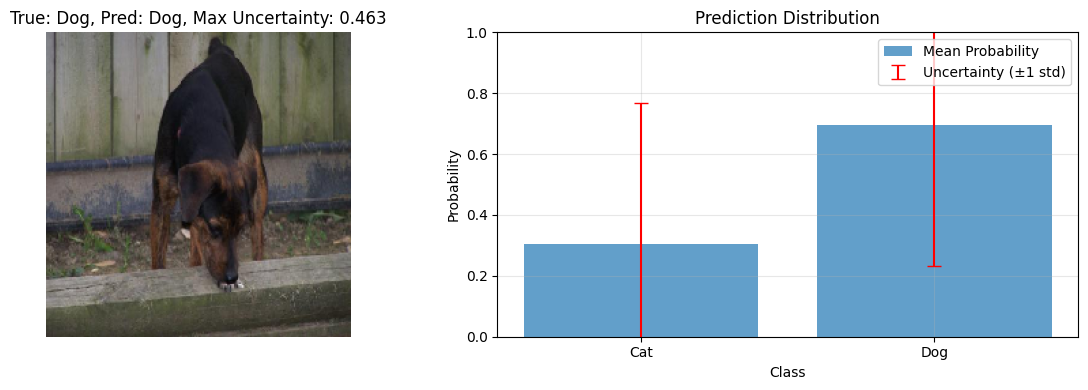

Detailed stats for sample 2190:
True label: Dog
Predicted label: Dog
Confidence (max probability): 0.695
Uncertainty in prediction: 0.463
Max uncertainty across classes: 0.463
Prediction probabilities:
-Cat: 0.305 ± 0.463
-Dog: 0.695 ± 0.463
INCORRECT PREDICTION


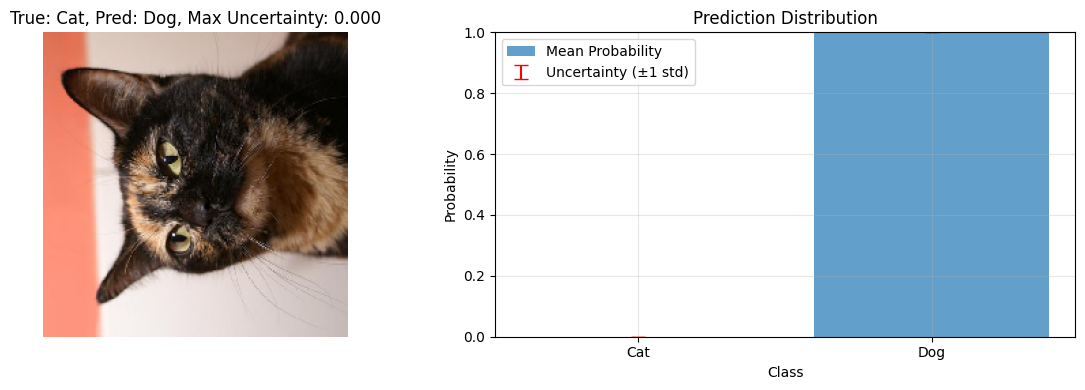

Detailed stats for sample 1653:
True label: Cat
Predicted label: Dog
Confidence (max probability): 1.000
Uncertainty in prediction: 0.000
Max uncertainty across classes: 0.000
Prediction probabilities:
-Cat: 0.000 ± 0.000
-Dog: 1.000 ± 0.000


In [24]:
if len(correct_idx) > 0:
    correct_sample = np.random.choice(correct_idx)
else:
    print("No correct predictions found!")
    correct_sample = None

if len(incorrect_idx) > 0:
    incorrect_sample = np.random.choice(incorrect_idx)
else:
    print("No incorrect predictions found!")
    incorrect_sample = None

# Visualize correct prediction
if correct_sample is not None:
    print("="*50)
    print("CORRECT PREDICTION")
    print("="*50)
    plot_prediction_with_uncertainty(correct_sample, True)

# Visualize incorrect prediction
if incorrect_sample is not None:
    print("" + "="*50)
    print("INCORRECT PREDICTION")
    print("="*50)
    plot_prediction_with_uncertainty(incorrect_sample, False)

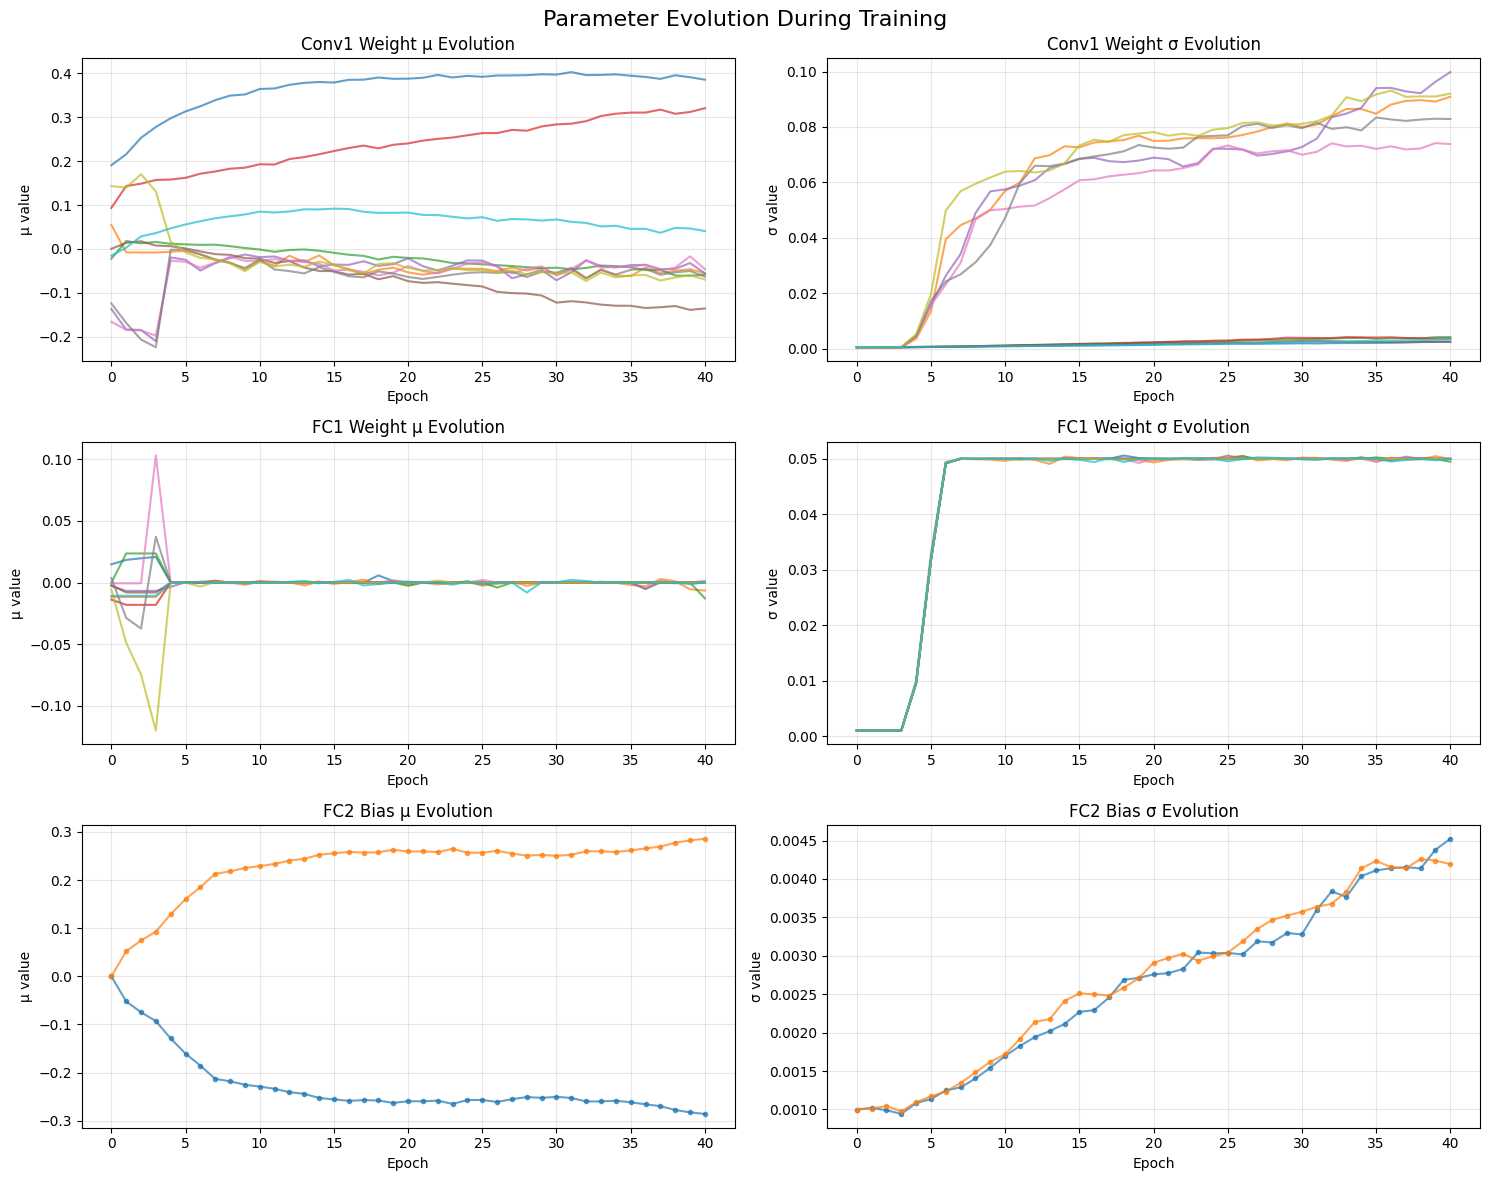

In [25]:
tracker = ParameterTracker(model, num_params_to_track=10)
tracker.history = checkpoint['tracker_history']
tracker.plot_evolution()